In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa import stattools
from IPython.display import HTML
import datetime
import seaborn as sns

pd.set_option('max_colwidth', 1000)

%run ./ping_helps.ipynb
%run ./plotting_helps.ipynb

clean = read_all()

clean['hour'] = clean['tstamp'].apply(lambda x: x.hour)
clean['day'] =  clean['tstamp'].apply(lambda x: x.isoweekday())  # 1 is Monday

In [25]:
# plt.rc('font', size=20)
# plt.figure(figsize=(15,8))
# ax = sns.boxplot(x="hour", y="lat", data=clean, showfliers=False);
# #plt.title('Internet speed to google.com over time.')
# plt.xlabel('');
# plt.ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])
# ax.set_xticklabels([])
# ax.set_xticks([])
# plt.savefig('/home/anthony/personalSite/content/project/internet-traffic/featured.jpg')

In [29]:
%run ./plotting_helps.ipynb

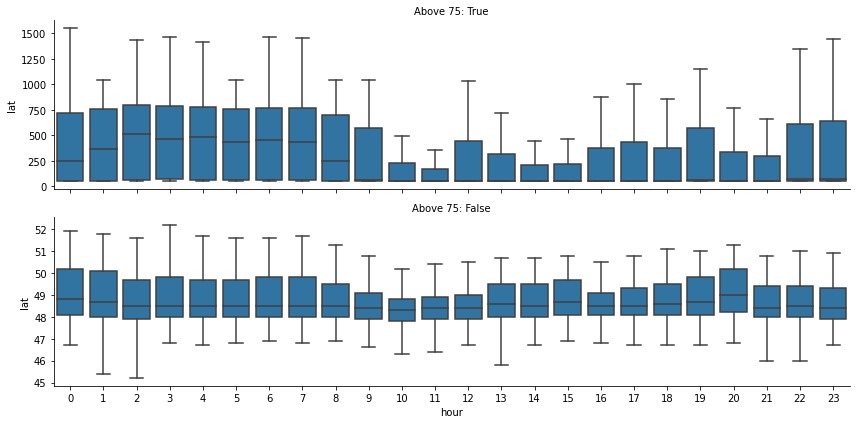

In [31]:
draw_split(var='hour', val='lat', perc=.75, dat=clean); 

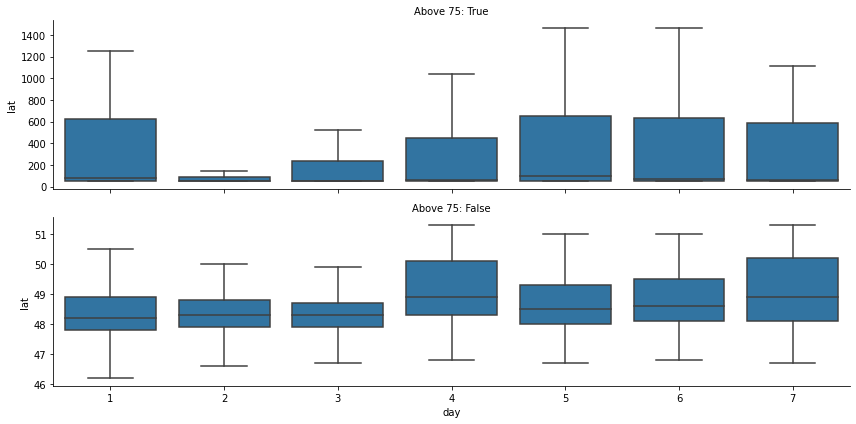

In [32]:
draw_split(var='day', val='lat', perc=.75, dat=clean); 